In [1]:
import numpyro
numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, DiscreteHMCGibbs

from jax import numpy as jnp
from jax import random

import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az

from dfply import *

%run -i 'model_helpers.py'
%run -i 'models.py'



,ID,condition,querytype,querydetail,estimate
40,0,2,A,warm,0.586667
41,0,2,AandB,warm and snowy,0.010000
42,0,2,AandnotB,warm and not snowy,0.626667
43,0,2,AgB,warm given snowy,0.010000
44,0,2,AgnotB,warm given not snowy,0.683333


In [41]:
def process_data(df):

    df = (df
          # .assign(is_one = df.estimate==1, is_zero = df.estimate==0)
          .groupby(["ID","condition","querytype","querydetail"], as_index=False)
          .agg({"estimate":"mean"})
          .assign(estimate = lambda x: x.estimate.replace({0:.005, 1:.995}))
         )
    
    return df

df = load_data_exp2() # see data_helpers.py
df = df[df["condition"]==2] # select "warm/snowy" condition only

df = process_data(df)
df.head()

,ID,condition,querytype,querydetail,estimate
0,0,2,A,warm,0.586667
1,0,2,AandB,warm and snowy,0.005000
2,0,2,AandnotB,warm and not snowy,0.626667
3,0,2,AgB,warm given snowy,0.005000
4,0,2,AgnotB,warm given not snowy,0.683333


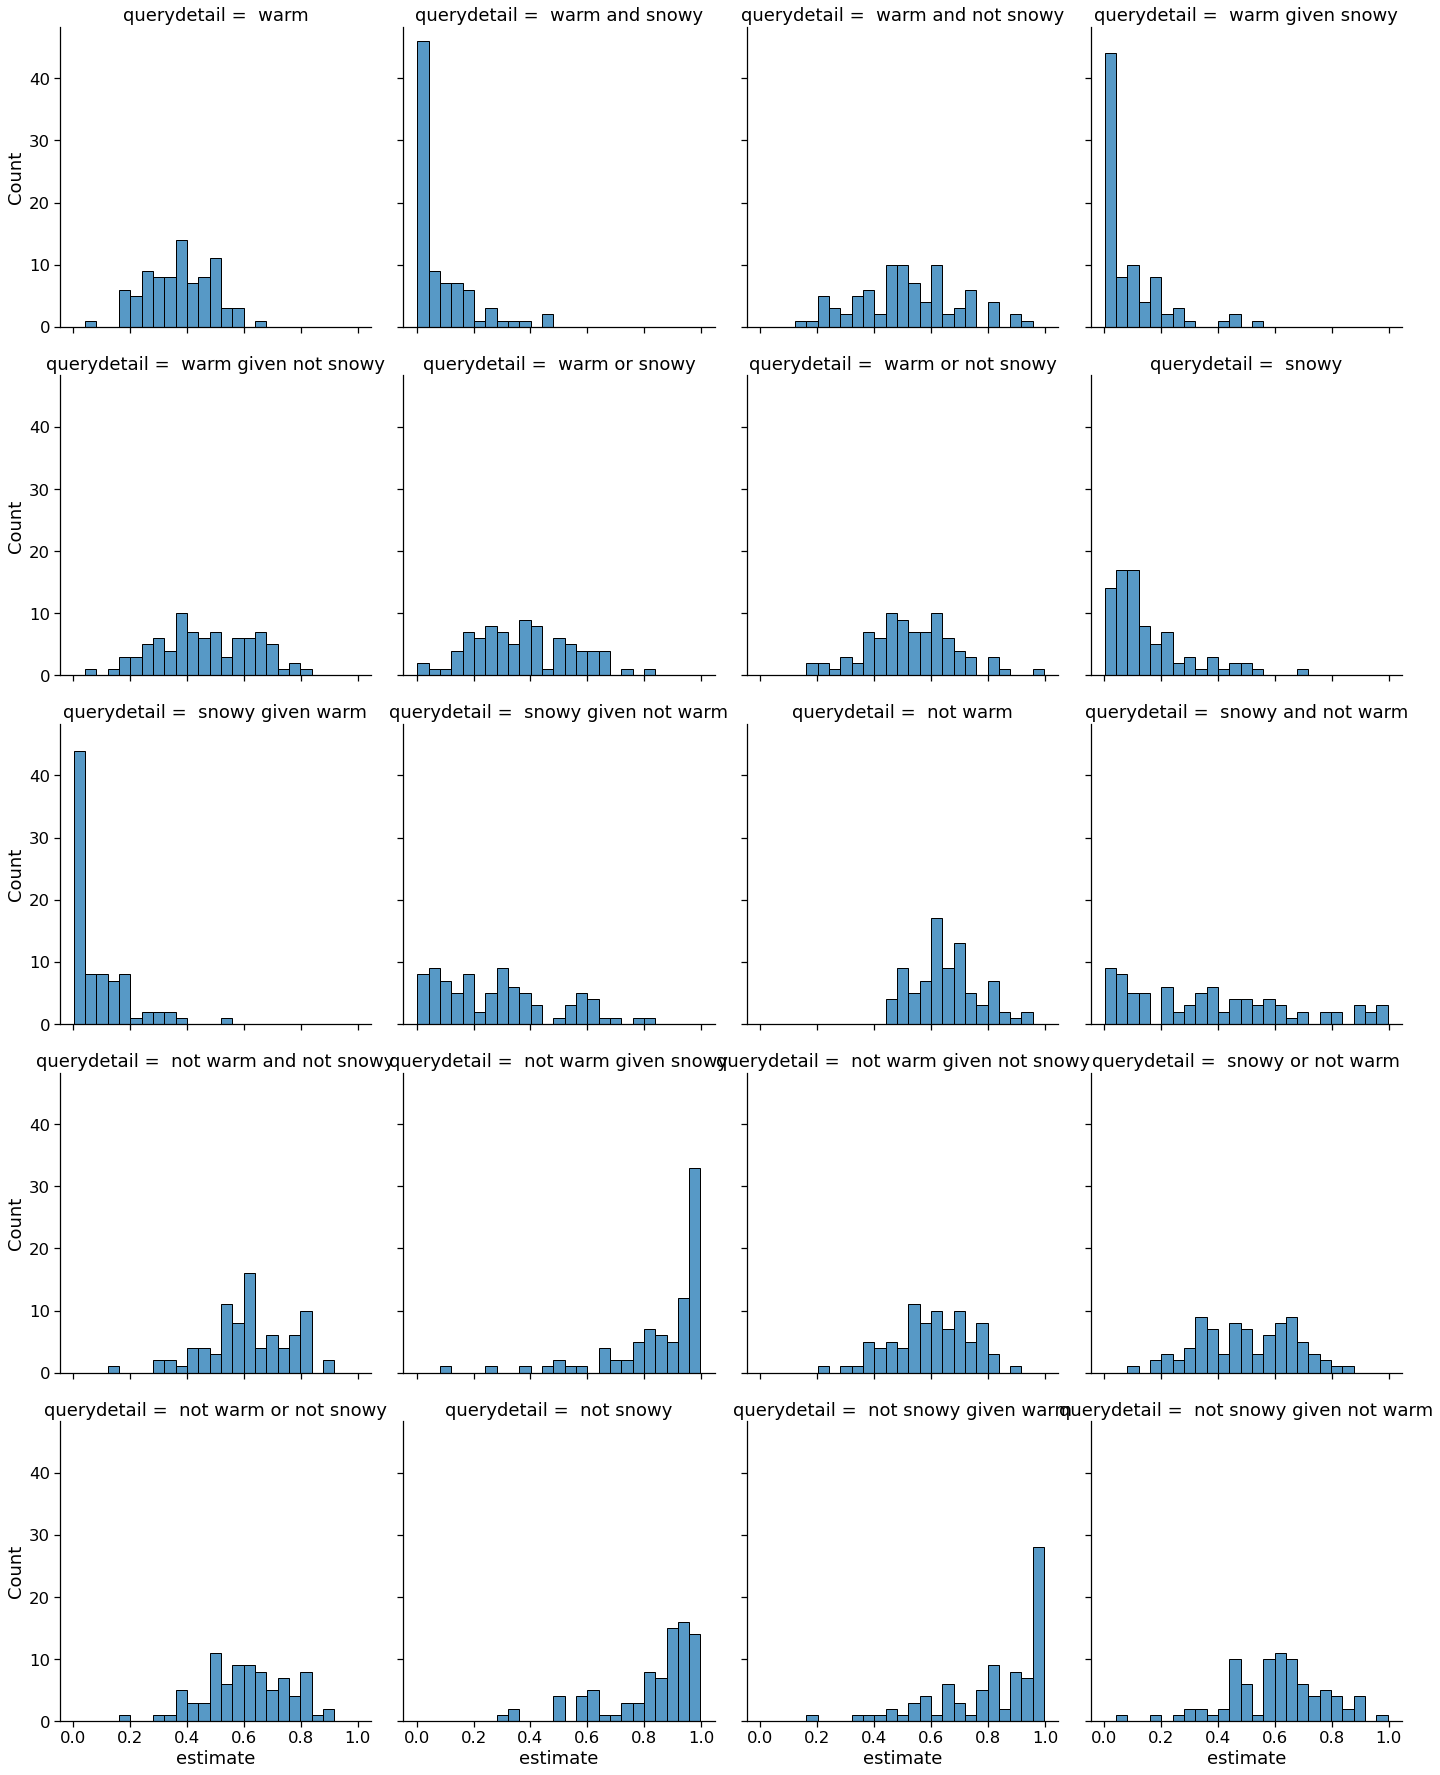

In [42]:
with sns.plotting_context("notebook", font_scale=1.5):
    sns.displot(df, x="estimate", col="querydetail", col_wrap=4, bins=25)

In [43]:
X_data, y_data = make_model_data(df) # see data_helpers.py

In [68]:
mcmc_bs_mlm = MCMC(NUTS(bayesian_sampler_complex_mlm, target_accept_prob=.90), # need the higher prob and more samples to get good rhats
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=2)
# 
mcmc_bs_mlm.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Participant mean response corr =  0.827
Query-level corr 0.917


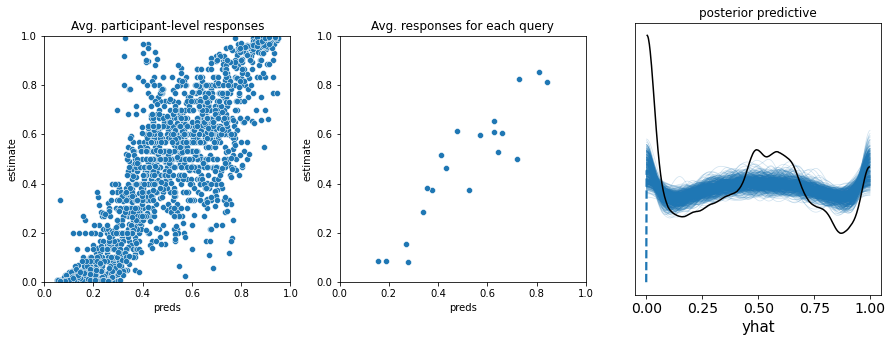

In [69]:
az_data_bs_mlm = make_arviz_data(mcmc_bs_mlm, bayesian_sampler_complex_mlm, X_data) # see model_helpers.py
plot_model_preds(df, az_data_bs_mlm)

## Mixture model

Need components for normal responses as well as ~0 and ~1 responses.

In [122]:

trial_ind_dict = {key:v for (key, v) in zip(np.unique(X_data["trial"]), range(0,20)) }
def bayesian_sampler_complex_mix(data, y=None):

    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds, n_obs = np.unique(subj).shape[0], np.unique(cond).shape[0], subj.shape[0]
    n_trial_types = np.unique(trial).shape[0]
    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])
    not_conjdisj = abs(1-jnp.array([is_conjdisj(i) for i in trial]))
    trial_type = jnp.array([trial_ind_dict[i] for i in trial])
    
    # population level parameters/priors
    k = numpyro.sample("k", dist.HalfNormal(50)) # noise parameter
    
# population mixture parameter

## trial-level mixing probs
    with numpyro.plate("trial_type", n_trial_types):
        mixing_probs_dist = numpyro.sample("mixing", dist.Dirichlet(jnp.ones(3)))
    
    mix_mu1 = .99
    mix_mu0 = .01
    k_50 = numpyro.sample("k_50", dist.Normal(0,10))
    mix_kval = 300+k_50
    mixing_ind = subj*n_trial_types+trial_type
    mixing_probs = mixing_probs_dist[mixing_ind, :]

    ## Simple mixing probs  
#     mixing_probs = numpyro.sample("mixing", dist.Dirichlet(jnp.ones(3)))
    
#     mix_mu1 = .99
#     mix_mu0 = .01
#     k_50 = numpyro.sample("k_50", dist.Normal(0,20))
#     mix_kval = 300+k_50
    
    
    # subject-level parameters/priors 
    with numpyro.plate("subj", n_Ps):
#         betas = numpyro.sample("beta", dist.Uniform(0.0, 1.0)) # bounded to [0,1] as in paper
        betas = numpyro.sample("beta", dist.LogNormal(-1., 1.))
#         N_deltas = numpyro.sample("N_delta", dist.HalfNormal(50))
#         N_primes = numpyro.sample("N_prime", dist.HalfNormal(50))
        N_deltas = numpyro.sample("N_delta", dist.Normal(0,3)) # 3/25/21, 11:10 PM changed this
        N_primes = numpyro.sample("N_prime", dist.Normal(0,3))
        
    # subject/query-level parameters/priors
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    
    beta = betas[subj] # use jnp.exp() if unbounded
    theta_ind = ((subj*n_conds)+cond)
    theta = thetas[theta_ind,:]
#     N = 1 + N_primes[subj] + N_deltas[subj] * not_conjdisj 
    N_lin = N_primes[subj] + N_deltas[subj] * not_conjdisj #  < -------------- gah, fix this 3/26/21, 9:41 AM
    N = 1 + jnp.exp(N_lin) # they required N be at least 1
    
    p_bs = prob_judge_BS(theta, X_num, X_denom, N, beta)
    
    # Likelihood
    with numpyro.plate("data", len(trial)):
        yhat = jnp.stack(
            [p_bs, 
             jnp.ones(n_obs)*mix_mu1, 
             jnp.ones(n_obs)*mix_mu0 ], 
            -1)
        mix_k = jnp.stack(
            [jnp.ones(n_obs)*k, 
             jnp.ones(n_obs)*mix_kval, 
             jnp.ones(n_obs)*mix_kval]
            , -1)
        numpyro.sample("yhat", MixtureBeta(yhat*mix_k, (1-yhat)*mix_k, mixing_probs), obs=y)
    
    return yhat


In [123]:
mcmc_bs_mix = MCMC(NUTS(bayesian_sampler_complex_mix, target_accept_prob=.80), # need the higher prob and more samples to get good rhats
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=1)
 
mcmc_bs_mix.run(random.PRNGKey(0), X_data, y_data)

sample: 100%|██████████| 2000/2000 [31:18<00:00,  1.06it/s, 1023 steps of size 6.72e-04. acc. prob=0.79]


Participant mean response corr =  0.804
Query-level corr 0.888


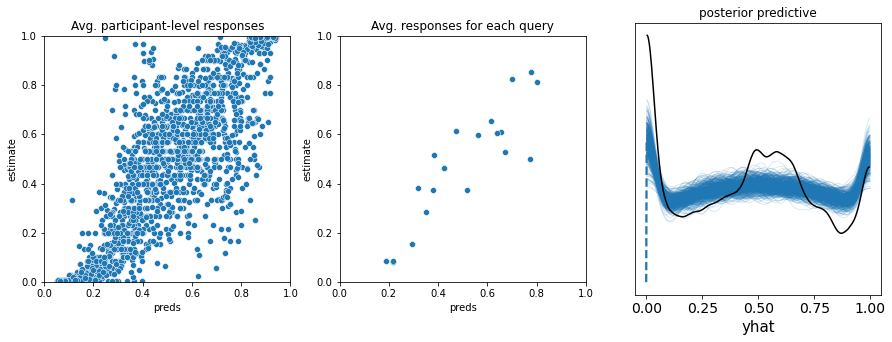

In [124]:
az_data_bs_mix = make_arviz_data(mcmc_bs_mix, bayesian_sampler_complex_mix, X_data) # see model_helpers.py
plot_model_preds(df, az_data_bs_mix)

In [121]:
print("num divergences =", count_divergences(az_data_bs_mix))

num divergences = 0


~~it works! in principle.~~ just kidding! it doesn't work

In [84]:
a_vec = jnp.stack([jnp.ones(10)*2, jnp.ones(10)*4], -1)
b_vec = jnp.stack([jnp.ones(10)*2, jnp.ones(10)*4], -1)
mixing_vec = jnp.stack([jnp.ones(10)*.5, jnp.ones(10)*.5], -1)
MixtureBeta(a_vec, b_vec, mixing_vec).sample(random.PRNGKey(0))

DeviceArray([0.40870768, 0.43264607, 0.50035226, 0.6173958 , 0.38380274,
             0.5238202 , 0.1303392 , 0.34570032, 0.26540968, 0.7439098 ],            dtype=float32)

In [112]:
z = dist.Dirichlet(jnp.ones((2)))

# z.sample(random.PRNGKey(1))[0,:]
with numpyro.plate("whatever", 5):
    x = numpyro.sample("test", z, rng_key = random.PRNGKey(0))

    
MixtureBeta(a_vec, b_vec, x[[1,2,3,4,5,1,2,3,4,5],:]).sample(random.PRNGKey(0))

ValueError: Incompatible shapes for broadcasting: ((10, 2), (10, 2), (5, 2))